In [39]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Imports

In [40]:
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, RobustScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score, classification_report
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.tree import DecisionTreeClassifier , export_graphviz
import graphviz



warnings.filterwarnings('ignore')

# Data 

In [41]:
load_dotenv()

True

In [42]:
data_get_env =os.getenv("DATA_HR")

In [43]:
os.chdir('/Users/felixhaberl/code/Emroullier/hr-data-analytics')

In [44]:
data = pd.read_csv(data_get_env)

In [45]:
data.head(5)

,ID,Name,Department,GEO,Role,Rising_Star,Will_Relocate,Critical,Trending Perf,Talent_Level,...,Emp_Competitive_4,Emp_Competitive_5,Emp_Collaborative_1,Emp_Collaborative_2,Emp_Collaborative_3,Emp_Collaborative_4,Emp_Collaborative_5,Sensor_StepCount,Sensor_Heartbeat(Average/Min),Sensor_Proximity(1-highest/10-lowest)
0,1,BRADDY,Operations,US,VP,NaN,0,1.0,3,6,...,2,2,2,2,2,1,5,1841,61,9
1,2,BORST,Sales,UK,Senior Director,NaN,0,NaN,3,6,...,4,1,3,2,5,1,5,1990,90,8
2,3,BIRDWELL,Finance,France,Senior Director,NaN,0,NaN,3,6,...,2,5,2,2,4,4,4,3193,80,8
3,4,BENT,Human Resources,China,Senior Director,NaN,0,NaN,3,6,...,5,1,1,2,4,4,1,3248,77,6
4,5,BAZAN,IT,Korea,Director,NaN,0,NaN,3,6,...,5,3,5,1,2,5,4,3149,80,10


# Data Preparation

## Column cleaning: Droping and renaming

In [46]:
data.drop(columns = ['ID','Name','Rising_Star', 'Trending Perf', 'Talent_Level',
                     'Validated_Talent_Level', 'EMP_Sat_OnPrem_1', 'EMP_Sat_OnPrem_2',
                     'EMP_Sat_OnPrem_3','EMP_Sat_Remote_3', 'EMP_Sat_Remote_4','EMP_Sat_Remote_5',
                     'EMP_Engagement_2','EMP_Engagement_3','EMP_Engagement_4',
                     'EMP_Engagement_5','CSR Factor','sales'], inplace = True)

data = data.rename(columns={
    'Sensor_Heartbeat(Average/Min)': 'Sensor_Heartbeat',
    'Sensor_Proximity(1-highest/10-lowest)': 'Sensor_Proximity'
})

In [47]:
# Convert column names to lower snake case
data.columns = data.columns.str.lower().str.replace(' ', '_').str.replace('-', '_').str.replace('.', '_')

In [48]:
# combine all the men_leave and the women_leave column

data['leave'] = data['women_leave'].fillna(data['men_leave'])
data['leave'] = data['leave'].fillna(0)
data.drop(columns = ['women_leave', 'men_leave'], inplace = True)

## Handling NANs

In [49]:
# checking missing values

data.isnull().sum().sort_values(ascending=False)

critical                 14519
emp_sat_onprem_4           128
emp_sat_onprem_5           128
department                   0
emp_competitive_5            0
emp_identity                 0
emp_role                     0
emp_position                 0
emp_title                    0
emp_competitive_1            0
emp_competitive_2            0
emp_competitive_3            0
emp_competitive_4            0
emp_collaborative_2          0
emp_collaborative_1          0
emp_work_status_4            0
emp_collaborative_3          0
emp_collaborative_4          0
emp_collaborative_5          0
sensor_stepcount             0
sensor_heartbeat             0
sensor_proximity             0
emp_work_status_5            0
emp_work_status2             0
emp_work_status_3            0
number_project               0
role                         0
will_relocate                0
percent_remote               0
emp_sat_remote_1             0
emp_sat_remote_2             0
emp_engagement_1             0
last_eva

In [50]:
# impute binary missing values for critical column

data.loc[data['critical'].isna(), 'critical'] = 0

In [51]:
# covert gender column into binary classification column

data['gender'] = data['gender'].map({'F': 1, 'M': 0})

In [52]:
# impute missing values with mode as these are ranking/ordinal columns
columns_to_impute = ['emp_sat_onprem_4', 'emp_sat_onprem_5']

imputer = SimpleImputer(strategy='most_frequent')

data[columns_to_impute] = imputer.fit_transform(data[columns_to_impute])


In [53]:
# the target is imbalanced

data['left_company'].value_counts(normalize = True)

left_company
0    0.761917
1    0.238083
Name: proportion, dtype: float64

## Categorical Features ONLY Feature Engineering

In [54]:
# ordinal encoding for salary

ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit(data[['salary']])
data['encoded_salary'] = ordinal_encoder.transform(data[['salary']]) # 1 = low, 2 = medium, 3 = high
data.drop(columns = ['salary'], inplace = True)


In [55]:
# OneHotEncoding for department, geo and role

ohe_columns = ['department', 'geo', 'role']

ohe = OneHotEncoder(sparse_output = False)

ohe_data = ohe.fit_transform(data[ohe_columns])

ohe_df = pd.DataFrame(ohe_data, columns=ohe.get_feature_names_out(ohe_columns))

encoded_data = pd.concat([data, ohe_df], axis=1)

encoded_data.drop(columns = ['department', 'geo', 'role'], inplace = True)

# Feature and Target

In [56]:
# define x and y variables

X = encoded_data.drop(columns = 'left_company')

y = encoded_data['left_company']

## Feature correlation

<Axes: >

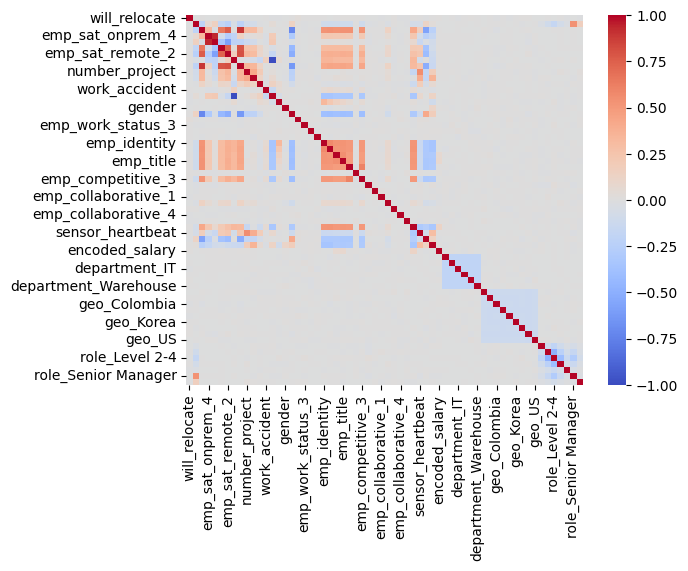

In [57]:
# Correlation Matrix
sns.heatmap(encoded_data.corr(), cmap='coolwarm')

In [58]:
# visualise the correlation

# Calculate the correlation matrix
corr_matrix = encoded_data.corr()

# Create an empty list to store correlation pairs
correlation_pairs = []

# Iterate through the correlation matrix
for i, col in enumerate(corr_matrix.columns):
    for j, index in enumerate(corr_matrix.index):
        if i < j:  # Only store pairs once to avoid duplicates and self-correlation
            correlation_pairs.append([index, col, corr_matrix.iloc[j, i]])

# Convert the list to a DataFrame
corr_df = pd.DataFrame(correlation_pairs, columns=['feature_1', 'feature_2', 'correlation'])

corr_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation

corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] # Remove self correlation

corr_df.head()


,feature_1,feature_2,correlation
180,emp_sat_onprem_5,emp_sat_onprem_4,0.930062
126,last_evaluation,percent_remote,0.897223
352,last_evaluation,emp_sat_remote_2,0.805922
297,last_evaluation,emp_sat_remote_1,0.796292
124,emp_sat_remote_2,percent_remote,0.762327


In [59]:
# remove highly correlated features >= 0.7 or <= -0.7

correlated_features = corr_df[(corr_df['correlation'] >= 0.7) | (corr_df['correlation'] <= -0.7)]

X.drop(columns = ['emp_sat_onprem_4', 'percent_remote', 'emp_sat_remote_2', 'emp_sat_remote_1', 'emp_engagement_1','critical'], inplace = True)


In [60]:
X.isnull().sum().sort_values(ascending=False)

will_relocate                 0
geo_Colombia                  0
sensor_proximity              0
leave                         0
encoded_salary                0
department_Finance            0
department_Human Resources    0
department_IT                 0
department_Operations         0
department_Sales              0
department_Warehouse          0
geo_Australia                 0
geo_China                     0
geo_France                    0
sensor_stepcount              0
geo_Japan                     0
geo_Korea                     0
geo_Turkey                    0
geo_UK                        0
geo_US                        0
role_Director                 0
role_Level 1                  0
role_Level 2-4                0
role_Manager                  0
role_Senior Director          0
role_Senior Manager           0
sensor_heartbeat              0
emp_collaborative_5           0
emp_sat_onprem_5              0
emp_work_status_5             0
last_evaluation               0
number_p

# Decision Tree

## Train / Test Split of features and target

In [61]:
X = X.values
y = y.values

In [62]:
# Create a train set and a test set, train = 10499, test = 4500
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=10)


## Training of Decision Tree Classifier

In [63]:
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=2)
tree_clf.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=2, random_state=2)

In [64]:
# Export model graph

export_graphviz(tree_clf, out_file="hr_data.dot", 
                feature_names=encoded_data.drop(columns=['emp_sat_onprem_4', 'percent_remote', 'emp_sat_remote_2', 'emp_sat_remote_1', 'emp_engagement_1','critical','left_company']).columns,
                class_names=['0','1'], 
                rounded=True, filled=True)

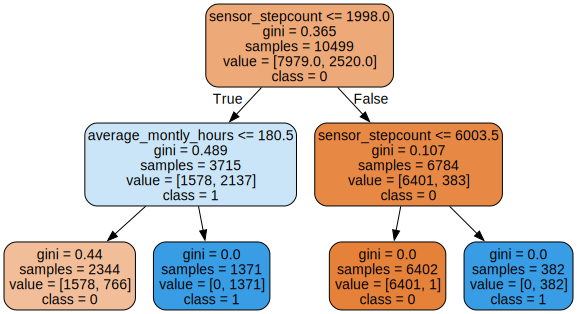

In [65]:
# Import model graph
with open("hr_data.dot") as f:
    dot_graph = f.read()
    display(graphviz.Source(dot_graph))

## Accuracy of the Decision Tree Classifier

In [66]:
y_pred = tree_clf.predict(X_test)

In [67]:
#Accuracy score from sklearn
mean_accuracy=tree_clf.score(X_test,y_test)

In [68]:
#Accuracy score from sklearn
acc = accuracy_score(y_test, y_pred)

In [69]:
#comparing the two ways to calculate the accuracy
acc, mean_accuracy

(0.9284444444444444, 0.9284444444444444)

In [70]:
class_probabilities=tree_clf.predict_proba(X_test)

In [79]:
class_probabilities[:,0].mean()

np.float64(0.7636139419244343)